# Sentiment Analysis

### Objective: Build a deep learning model using bert embedding(Text classification). 

#### Attribute Explanation:

Original Text: Original text of the chat <br>
Relevant Text: Key sentence of the original text <br>
Recitified_Score_2:ignore <br>
Entity_name: sentence belong to which entity <br>
DM_Score:4 classes(1-negative,2-neutral,3-positive,4-extreme positive) <br>
Neutral_Non_Neutral-Neutral or non-neutral <br>

### 1. Data Loading

In [71]:
!pip install -qq transformers
# importing the relevant libraries
import torch.nn.functional as F
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [72]:
## Loading the data into python
df = pd.read_excel("Neutral_Non_Neutral_Training.xlsx")

### 2. Exploratory Data Analysis

In [73]:
# Shape of the data
df.shape

(7491, 7)

In [74]:
## Information of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7491 entries, 0 to 7490
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Filename             7491 non-null   object
 1   Original Text        7491 non-null   object
 2   Relevant_Text        7491 non-null   object
 3   Recitified_Score_2   7491 non-null   int64 
 4   Entity_name          7491 non-null   object
 5   DM_Score             7491 non-null   int64 
 6   Neutral_Non_Neutral  7491 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 409.8+ KB


There are total 7491 observations and 7 features in this data set. There are 4 columns of object(string) data type and 3 of them of integer. <br> 
As, we can see no null or missing values in this data set.



In [75]:
# displaying first few records
df.head()

,Filename,Original Text,Relevant_Text,Recitified_Score_2,Entity_name,DM_Score,Neutral_Non_Neutral
0,Final_Prediction_Entity_Extraction_8001.csv,"In that case, I will recommend you sign a long...",sign a long term lease,4,renewed,4,1
1,Final_Prediction_Entity_Extraction_8501.csv,So personally I love the apartment the buildin...,all the office people,2,management,2,2
2,Final_Prediction_Entity_Extraction_1751.csv,And yes I’m in the B2 floor plan,I’m in the B2 floor plan,2,unit_features,2,2
3,Final_Prediction_Entity_Extraction_1251.csv,I love living in this community.,I love living in this community,4,community,4,1
4,Final_Prediction_Entity_Extraction_8251.csv,I would say they are comparable to gyms at hig...,I would say they are comparable to gyms,3,fitness_center,3,1


In [76]:
## Summary statistics of numeric fields
df.describe()

,Recitified_Score_2,DM_Score,Neutral_Non_Neutral
count,7491.000000,7491.000000,7491.000000
mean,2.887999,2.920972,1.252570
std,1.094411,1.019386,0.434515
min,0.000000,1.000000,1.000000
25%,2.000000,2.000000,1.000000
50%,3.000000,3.000000,1.000000
75%,4.000000,4.000000,2.000000
max,4.000000,4.000000,2.000000


Looking at the quintiles we can say that these columns hold discrete values. (As has been instructed, Rectified_Score_2 can be ignored from further analysis)

In [77]:
total_files_used = df['Filename'].nunique()
if total_files_used == df.shape[0]:
    print("Each record is captured from a unique file.")
else:
    print(f"Data is extracted from {total_files_used} files in this dataset.")

Data is extracted from 38 files in this dataset.


In [78]:
# DM_Score:4 classes(1-negative,2-neutral,3-positive,4-extreme positive)
# creating a new column
conditions = [(df['DM_Score'] == 1),
             (df['DM_Score'] == 2),
             (df['DM_Score'] == 3),
             (df['DM_Score'] == 4),]
values = ["negative", "neutral", "positive", "extreme positive"]
df["Sentiment"] = np.select(conditions, values)
df["Sentiment"].value_counts()

extreme positive    2846
positive            1980
neutral             1892
negative             773
Name: Sentiment, dtype: int64

In [79]:
df["Sentiment"].value_counts(normalize=True)

extreme positive    0.379923
positive            0.264317
neutral             0.252570
negative            0.103190
Name: Sentiment, dtype: float64

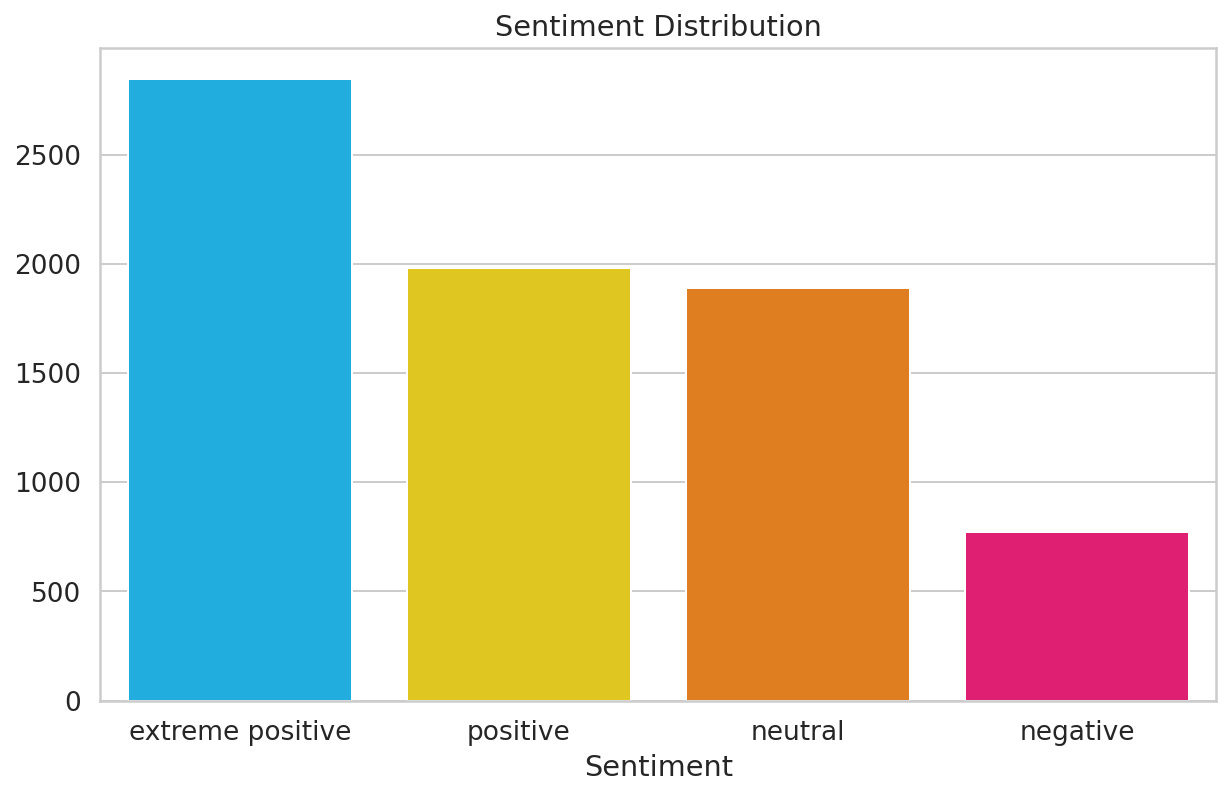

In [80]:
# plot sentiment distribution
plt.figure(figsize=(10,6))
sns.countplot(x = "Sentiment", data = df,
              
             order=df['Sentiment'].value_counts().index);
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("")
plt.show()

This plot depicts sentiment distribution. We can see that more than 50% of observations comprise of positive sentiments (including extreme positives). And only 10% of the observations are of negative sentiment. As we can see, data is imbalanced.

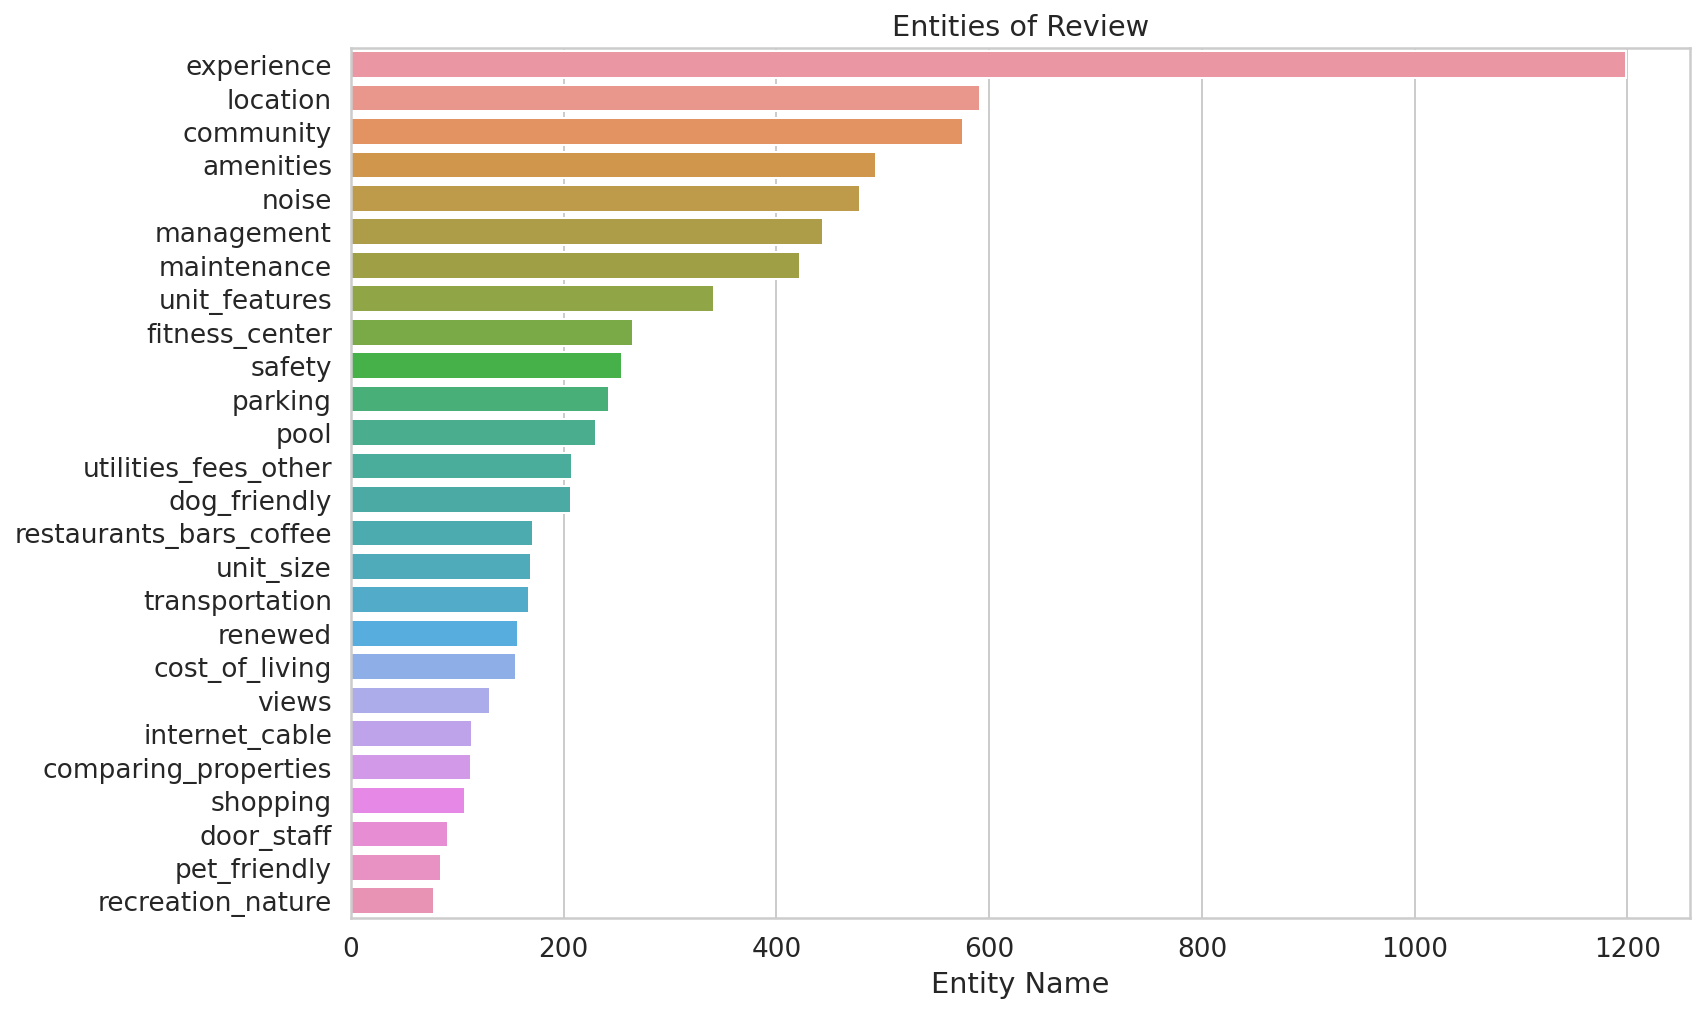

In [81]:
# plot entitites
plt.figure(figsize=(12,8))
entities = df['Entity_name'].value_counts()
sns.barplot(x = entities.values, y = entities.index)
plt.title("Entities of Review")
plt.xlabel("Entity Name")
plt.ylabel("")
plt.show()

This plot shows that consumers care more about experience, location, ambience more than anything else.

In [82]:
# length distribution
def plot_length_distribution(text):     
    """Plots the sample length distribution.     
    # Arguments         
        text: list, sample text   
        Returns: plot of length distribution
    """
    plt.figure(figsize=(12,6))
    plt.hist([len(s) for s in text], 30)
    plt.xlabel('Length of a text record')     
    plt.ylabel('Number of Records')     
    plt.title('Text length distribution')    
    plt.show()


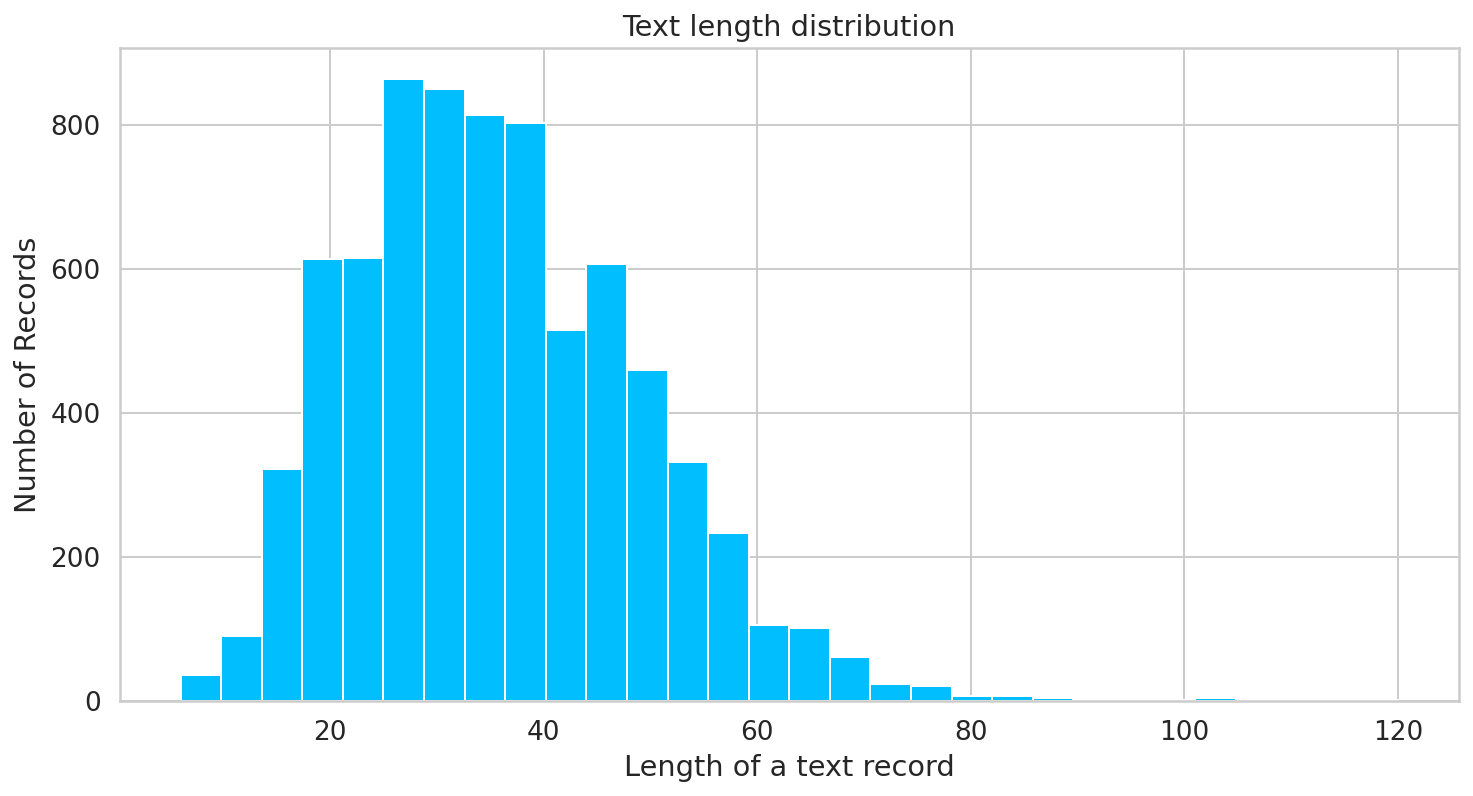

In [83]:
plot_length_distribution(df["Relevant_Text"])

There are some records/texts with length more than 200. Let us filter to see how many records have more than 250 length

In [84]:
filter_len = df["Relevant_Text"].str.encode(encoding='utf-8').str.len()
df[["Relevant_Text"]][filter_len>=250].count()

Relevant_Text    0
dtype: int64

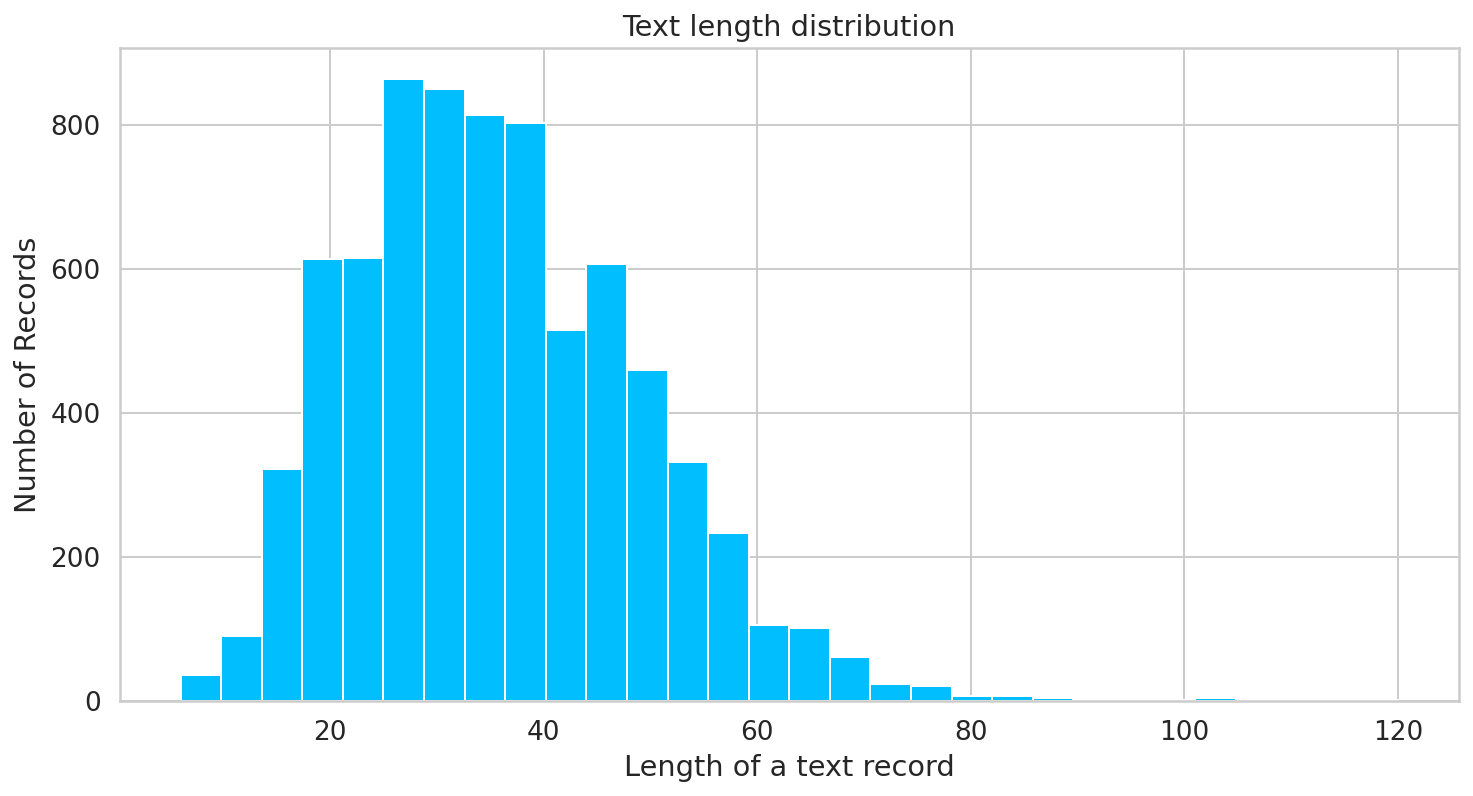

In [85]:
# plotting relevant text without any cleansing
plot_length_distribution(df["Relevant_Text"])

Relevant text seems to be normalized with not so many extreme values. Hence, Taking Relevant text as our input parameter. Also, Relevant_Text does not contain any redundant word as the column Original Text

In [86]:
## Concatenating the Entity_name and Relevant_Text columns

df["Review_Col"] = df["Relevant_Text"]+" "+df["Entity_name"]

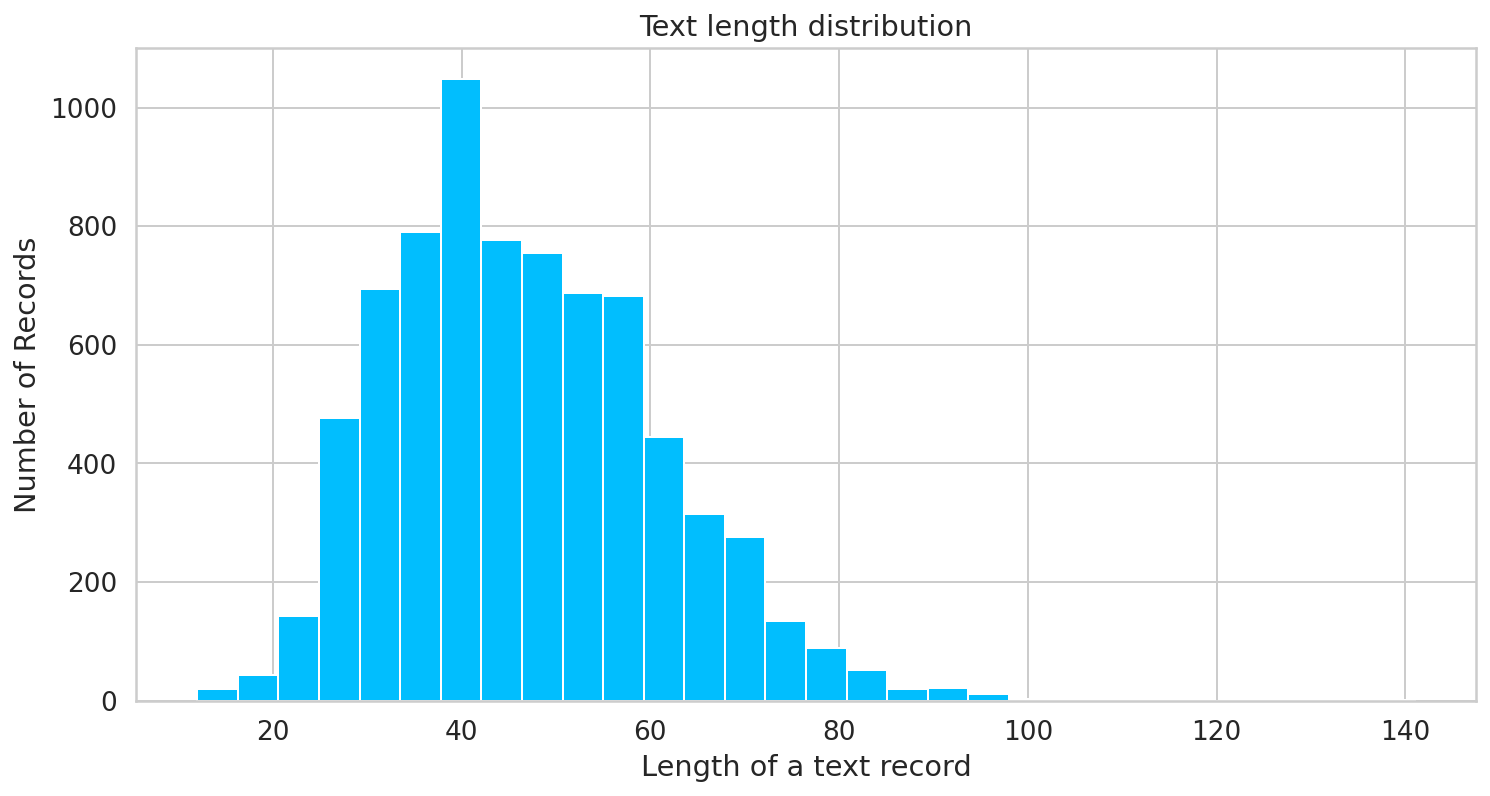

In [87]:
# plotting Review_Col
plot_length_distribution(df["Review_Col"])

### 3. Model Building

In [88]:
## name of the bert model, which will be used
bert_model = 'bert-base-cased'

In [89]:
tokenizer = BertTokenizer.from_pretrained(bert_model)

In [90]:
token_lens = []
for txt in df.Review_Col:
  tokens = tokenizer.encode(txt, max_length=200, truncation=True)
  token_lens.append(len(tokens))

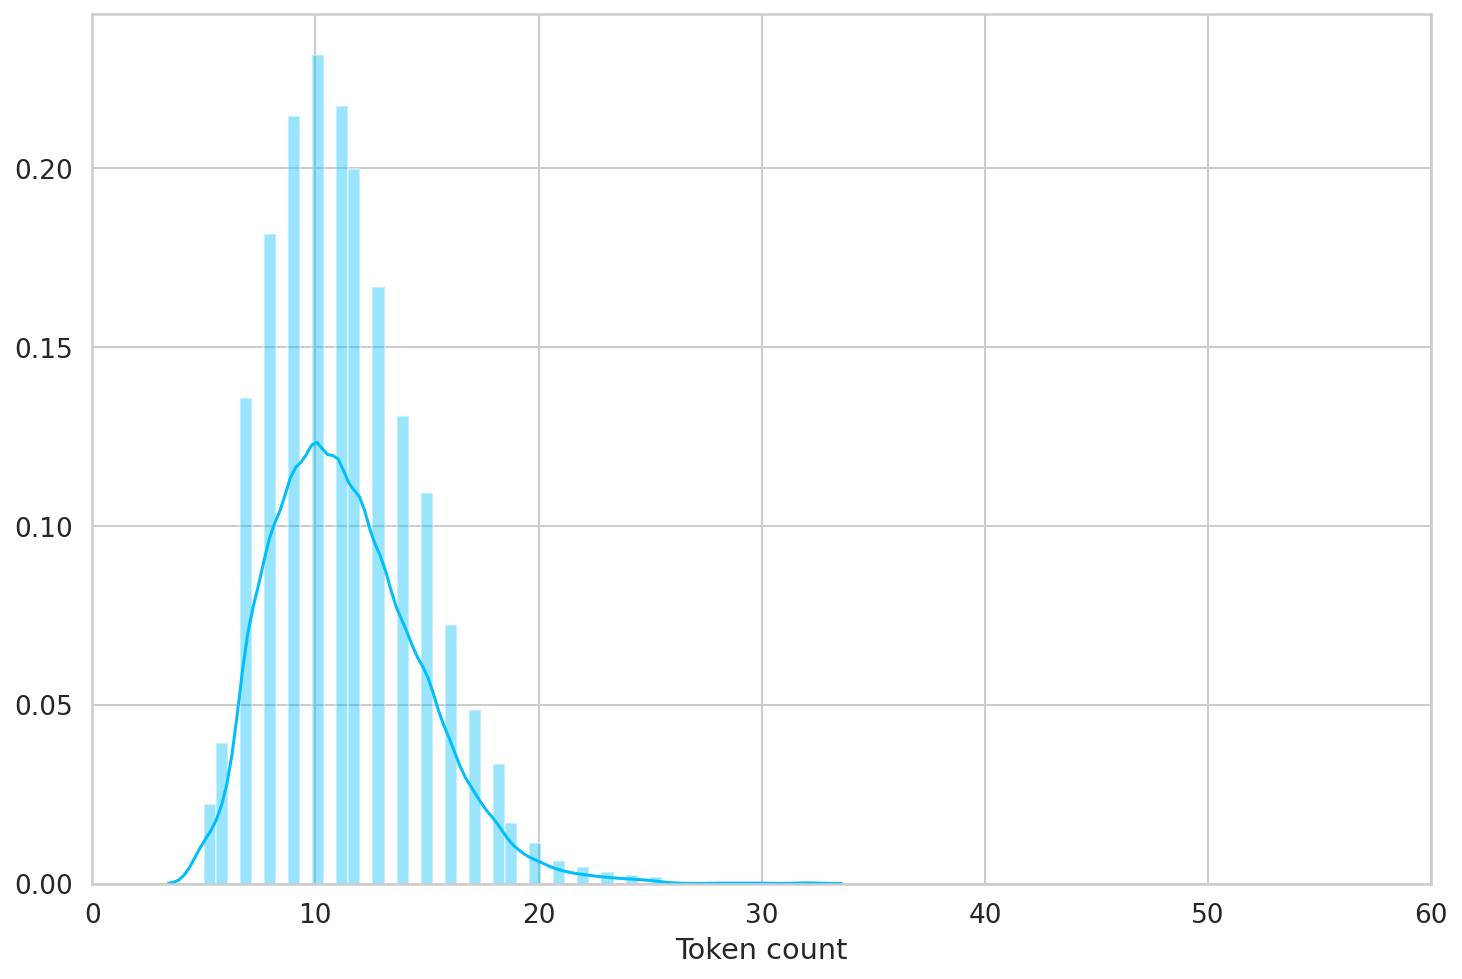

In [91]:
## Checking the distribution of length of reviews
sns.distplot(token_lens)
plt.xlim([0, 60]);
plt.xlabel('Token count');

In [92]:
## As we can see that most of the reviews seem to contain word less than  40 tokens, So taking max_length as 40
max_length = 40


In [93]:
## Changing the target value because of out of bound index error.
target_mapping = {
     1 : 0,
    2 : 1,
    3: 2,
    4 : 3
}

df["DM_Score"].replace(target_mapping, inplace=True)
df.head()

,Filename,Original Text,Relevant_Text,Recitified_Score_2,Entity_name,DM_Score,Neutral_Non_Neutral,Sentiment,Review_Col
0,Final_Prediction_Entity_Extraction_8001.csv,"In that case, I will recommend you sign a long...",sign a long term lease,4,renewed,3,1,extreme positive,sign a long term lease renewed
1,Final_Prediction_Entity_Extraction_8501.csv,So personally I love the apartment the buildin...,all the office people,2,management,1,2,neutral,all the office people management
2,Final_Prediction_Entity_Extraction_1751.csv,And yes I’m in the B2 floor plan,I’m in the B2 floor plan,2,unit_features,1,2,neutral,I’m in the B2 floor plan unit_features
3,Final_Prediction_Entity_Extraction_1251.csv,I love living in this community.,I love living in this community,4,community,3,1,extreme positive,I love living in this community community
4,Final_Prediction_Entity_Extraction_8251.csv,I would say they are comparable to gyms at hig...,I would say they are comparable to gyms,3,fitness_center,2,1,positive,I would say they are comparable to gyms fitnes...


### 3. Model Training

In [94]:
## Creating a pytorch dataset

class ReviewColDataSet(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_length):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_length = max_length
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_length,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation = True
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [95]:
## Splitting the data between train , validation and test set

df_train, df_test = train_test_split(
  df,
  test_size=0.25,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.9,
  random_state=RANDOM_SEED
)
df_train.shape, df_val.shape, df_test.shape

((5618, 9), (187, 9), (1686, 9))

In [96]:
## (Optional) Creating a basic function for data loading

def DataLoadFunc(df, tokenizer, max_length, batch_size):
  ds = ReviewColDataSet(
  reviews=df.Review_Col.to_numpy(),
  targets=df.DM_Score.to_numpy(),
  tokenizer=tokenizer,
  max_length=max_length
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

## Defining Batch Size
BATCH_SIZE = 16
## Loading the data using the DataLoadFun function

train_data_loader = DataLoadFunc(df_train, tokenizer, max_length, BATCH_SIZE)
val_data_loader = DataLoadFunc(df_val, tokenizer, max_length, BATCH_SIZE)
test_data_loader = DataLoadFunc(df_test, tokenizer, max_length, BATCH_SIZE)


data = next(iter(train_data_loader))
data.keys()


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [97]:
## For testing purposes (Checking shape)
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 40])
torch.Size([16, 40])
torch.Size([16])


In [98]:
class SentimentNeuralNetwork(nn.Module):
  def __init__(self, n_classes):
    super(SentimentNeuralNetwork, self).__init__()
    self.bert = BertModel.from_pretrained(bert_model)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [99]:
model = SentimentNeuralNetwork(len(df.Sentiment.unique()))
model = model.to(device)

In [100]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
##For testing purposes
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 40])
torch.Size([16, 40])


In [101]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2991, 0.3385, 0.2254, 0.1370],
        [0.5279, 0.1471, 0.2054, 0.1196],
        [0.4227, 0.1558, 0.2035, 0.2180],
        [0.5265, 0.0961, 0.2000, 0.1773],
        [0.3537, 0.1756, 0.2659, 0.2047],
        [0.3079, 0.3891, 0.1727, 0.1302],
        [0.3307, 0.2000, 0.2643, 0.2050],
        [0.2946, 0.1564, 0.2637, 0.2853],
        [0.3951, 0.1291, 0.2087, 0.2671],
        [0.5438, 0.1414, 0.2080, 0.1068],
        [0.1816, 0.2629, 0.4002, 0.1553],
        [0.4263, 0.2021, 0.2636, 0.1079],
        [0.4251, 0.1446, 0.3095, 0.1208],
        [0.3518, 0.2469, 0.2153, 0.1860],
        [0.4336, 0.1760, 0.2804, 0.1100],
        [0.4836, 0.0980, 0.2737, 0.1447]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [102]:
EPOCHS = 7
optimizer = AdamW(model.parameters(), lr=3e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [103]:
## Training Model

def TrainModel(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [104]:
## Evaluating Model
def EvaluateModel(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)


In [105]:
print(len(df_train))
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = TrainModel(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = EvaluateModel(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

5618
Epoch 1/7
----------
Train loss 0.8481122223575684 accuracy 0.6545033819864721
Val   loss 0.6333901683489481 accuracy 0.7914438502673796

Epoch 2/7
----------
Train loss 0.5186610102537088 accuracy 0.8081167675329299
Val   loss 0.6903801361719767 accuracy 0.7593582887700534

Epoch 3/7
----------
Train loss 0.32937602936131455 accuracy 0.8878604485582058
Val   loss 0.8869089931249619 accuracy 0.7272727272727272

Epoch 4/7
----------
Train loss 0.21348184631047348 accuracy 0.9305802776788893
Val   loss 1.0215492447217305 accuracy 0.7700534759358288

Epoch 5/7
----------
Train loss 0.13244474728675082 accuracy 0.9610181559273764
Val   loss 1.2123632008830707 accuracy 0.7754010695187166

Epoch 6/7
----------
Train loss 0.08875286203709204 accuracy 0.9781060875756498
Val   loss 1.4021172672510147 accuracy 0.7647058823529411

Epoch 7/7
----------
Train loss 0.05979019072335425 accuracy 0.9841580633677466
Val   loss 1.4364071985085805 accuracy 0.7486631016042781



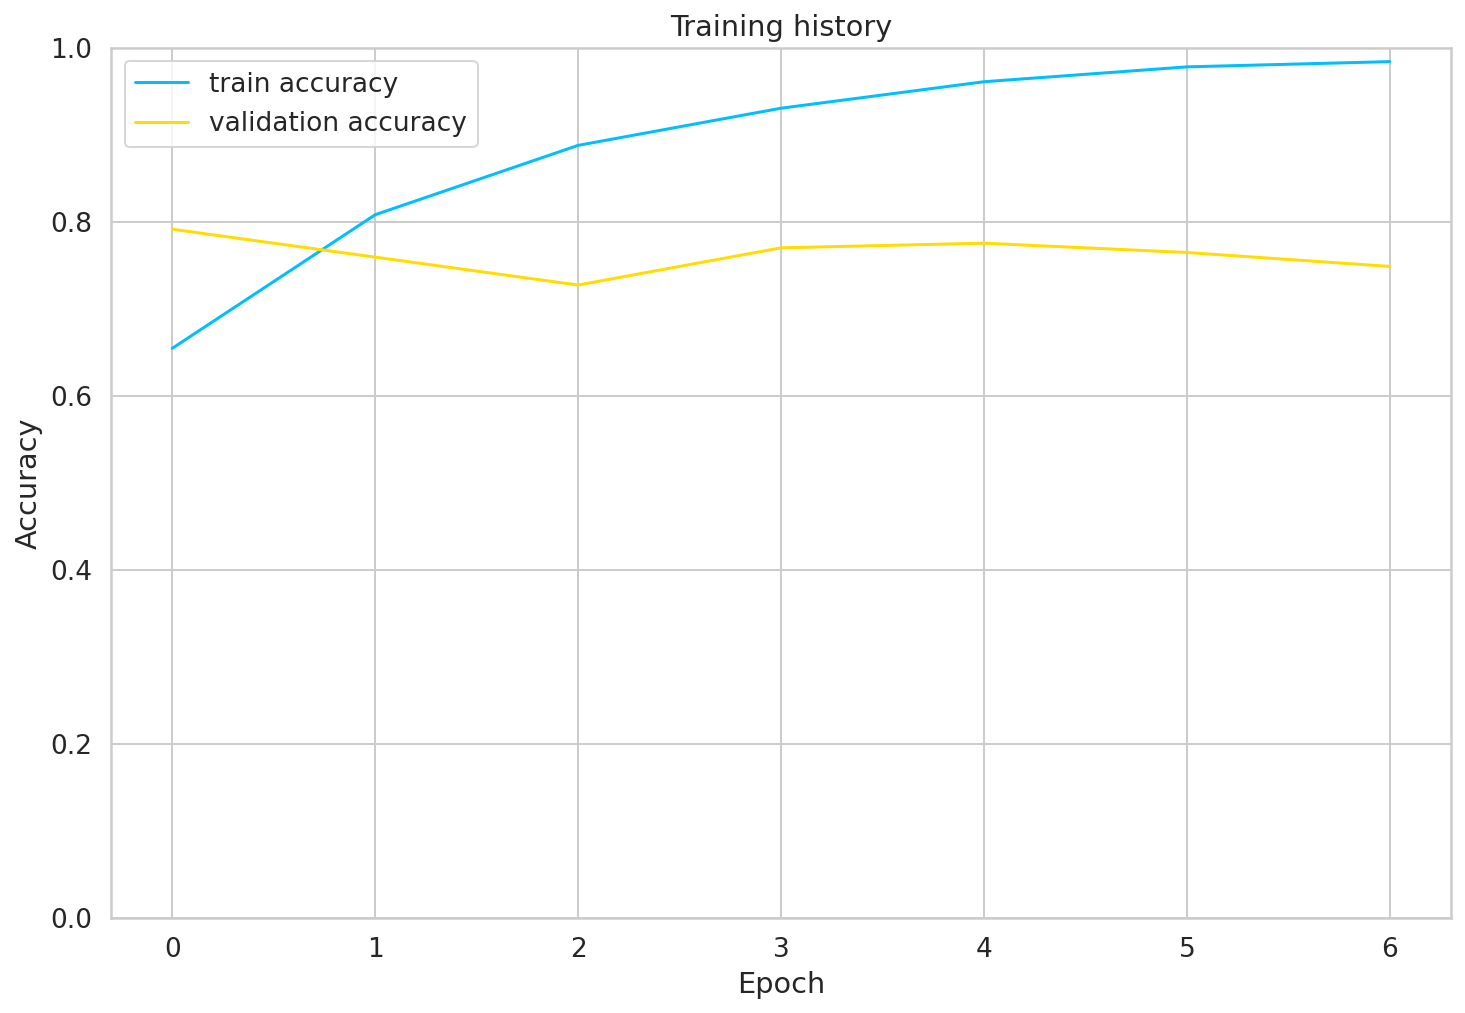

In [106]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [107]:
test_acc, _ = EvaluateModel(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.7651245551601424

### 4. Model Evaluation

In [108]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [109]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

### 5. Classification Report

In [110]:
print(classification_report(y_test, y_pred, target_names=df.Sentiment.unique()))

                  precision    recall  f1-score   support

extreme positive       0.72      0.72      0.72       158
         neutral       0.80      0.74      0.77       417
        positive       0.68      0.64      0.66       486
        negative       0.82      0.89      0.85       625

        accuracy                           0.77      1686
       macro avg       0.75      0.75      0.75      1686
    weighted avg       0.76      0.77      0.76      1686



### 6. Confusion Matrix

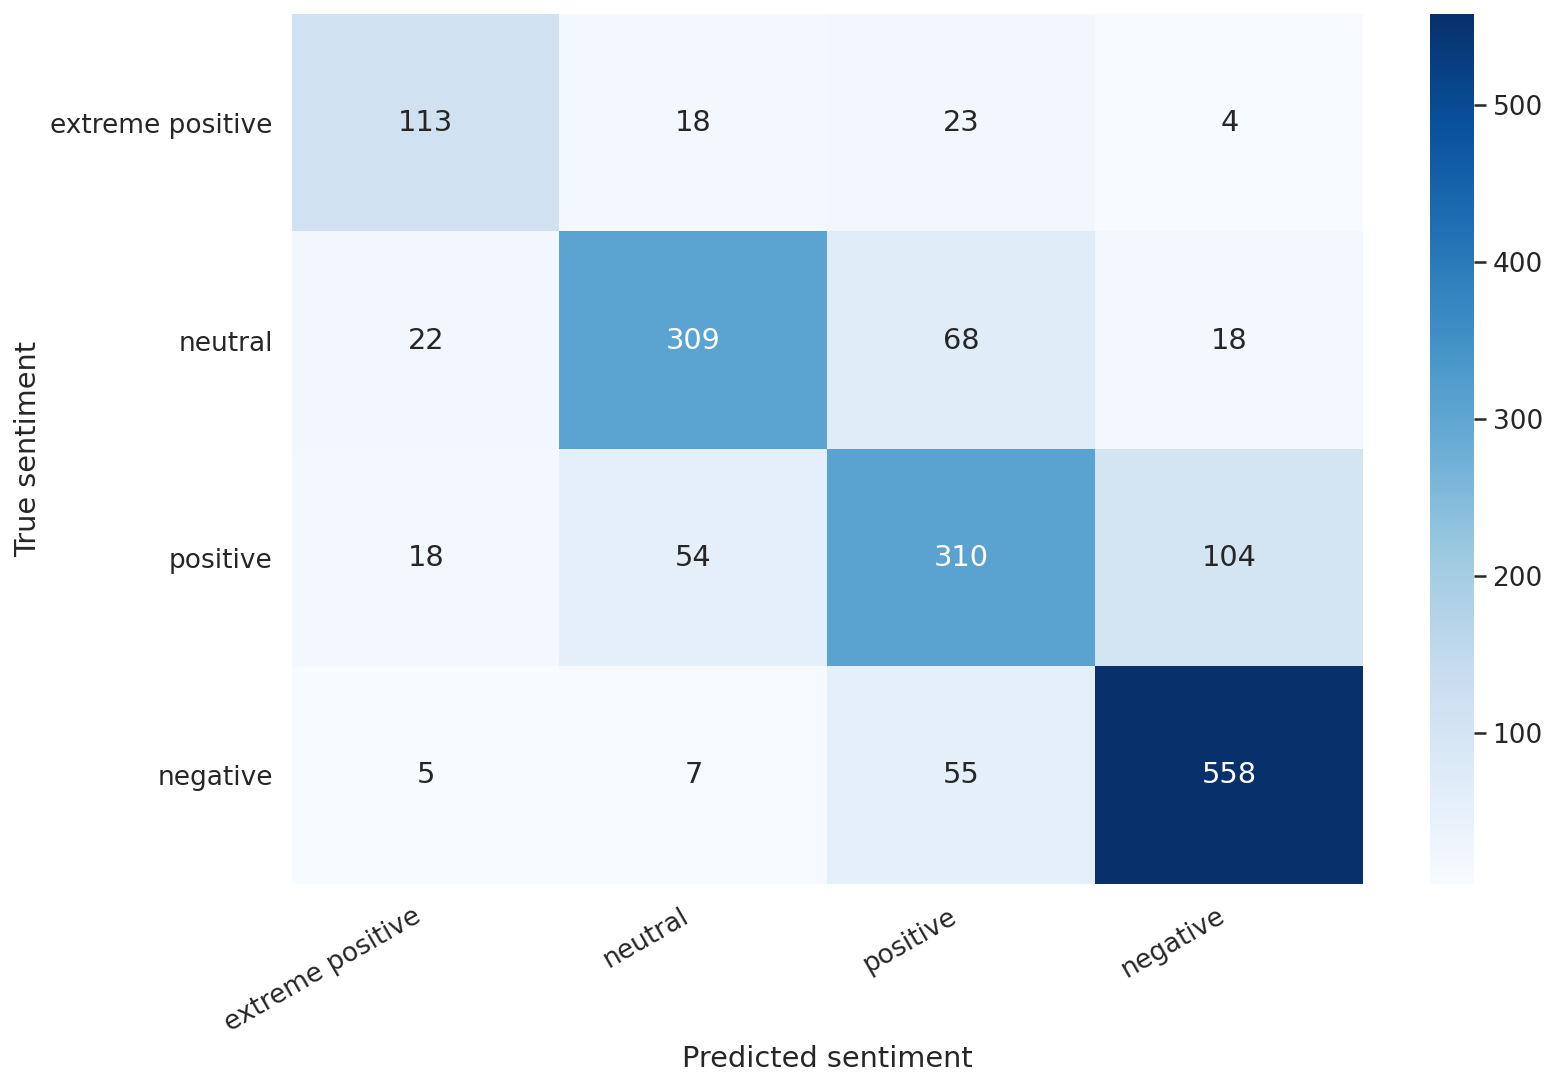

In [111]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=df.Sentiment.unique(), columns=df.Sentiment.unique())
show_confusion_matrix(df_cm)

### 7. Conclusion

With just few thousand records, we are able to get train and test accuracy of 96% , 76% respectively. The model is overfit and getting more data would definitely help tackle overfitting. We can also fine tune hyperparameters in order to reduce overfitting.